In [ ]:
# Методы борьбы с переобучением:
# 1) упростить модель
# 2) расширить набор исходных данных (аугментация)
# - Вырезать кусок картинки
# - Повороты/растяжения/сжатие
# - Шумы/зеркальное отражение
# 3) Early stopping
# 4) регуляризация (штраф для больших значений весов) <-- изм-ся вид аппрокс функции и ППЭ лосс-функции
# Регуляризация Тихонова: лосс-функция + lambda * alpha(i)^2
# Регуляризация LASSO: лосс-функция + lambda * abs(alpha(i))  <-- зануляет некоторые параметры модели
# 5) DropOut - drop connection и drop neuron

In [ ]:
# Нормировка
# Центрирование (вычитаем среднее) и стандартизация (делим на стд откл) + gamma и beta

In [ ]:
#!rm -r train test val
import numpy as np
import pandas as pd
import os
print(os.listdir())

['.config', 'plates.zip', 'sample_data']


In [ ]:
import zipfile
with zipfile.ZipFile('plates.zip', 'r') as zip_obj:
   zip_obj.extractall()

In [ ]:
!ls

plates.zip  sample_data  test  train


In [ ]:
!ls train

cleaned  dirty


In [ ]:
data_root = ''
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)


In [ ]:
!ls

plates.zip  sample_data  test  train  val


In [ ]:
import shutil 
from tqdm import tqdm

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 7 == 0:
            dest_dir = os.path.join(val_dir, class_name)
            shutil.move(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 58177.27it/s]


In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

In [ ]:
train_transforms1 = transforms.Compose([
    transforms.CenterCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms2 = transforms.Compose([
    transforms.CenterCrop(size=224),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms3 = transforms.Compose([
    transforms.RandomRotation(degrees=(80, 100)),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms4 = transforms.Compose([
    transforms.RandomRotation(degrees=(170, 190)),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms5 = transforms.Compose([
    transforms.RandomRotation(degrees=(270, 290)),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms6 = transforms.Compose([
    transforms.Grayscale(3),
    transforms.RandomRotation(degrees=(65, 75)),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms7 = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.15, p=1),
    transforms.ColorJitter(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms8 = transforms.Compose([
    transforms.CenterCrop(size=224),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])




val_transforms1 = transforms.Compose([
    transforms.CenterCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms2 = transforms.Compose([
    transforms.CenterCrop(size=224),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms3 = transforms.Compose([
    transforms.Grayscale(3),
    transforms.RandomRotation(degrees=(65, 75)),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms4 = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.15, p=1),
    transforms.ColorJitter(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms5 = transforms.Compose([
    transforms.CenterCrop(size=224),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset1 = torchvision.datasets.ImageFolder(train_dir, train_transforms1)
train_dataset2 = torchvision.datasets.ImageFolder(train_dir, train_transforms2)
train_dataset3 = torchvision.datasets.ImageFolder(train_dir, train_transforms3)
train_dataset4 = torchvision.datasets.ImageFolder(train_dir, train_transforms4)
train_dataset5 = torchvision.datasets.ImageFolder(train_dir, train_transforms5)
train_dataset6 = torchvision.datasets.ImageFolder(train_dir, train_transforms6)
train_dataset7 = torchvision.datasets.ImageFolder(train_dir, train_transforms7)
train_dataset8 = torchvision.datasets.ImageFolder(train_dir, train_transforms8)

val_dataset1 = torchvision.datasets.ImageFolder(train_dir, val_transforms1)
val_dataset2 = torchvision.datasets.ImageFolder(train_dir, val_transforms2)
val_dataset3 = torchvision.datasets.ImageFolder(train_dir, val_transforms3)
val_dataset4 = torchvision.datasets.ImageFolder(train_dir, val_transforms4)
val_dataset5 = torchvision.datasets.ImageFolder(train_dir, val_transforms5)

In [ ]:
print(len(train_dataset1))
print(len(train_dataset2))
print(len(train_dataset3))
print(len(train_dataset4))
print(len(train_dataset5))

34
34
34
34
34


In [ ]:
train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2, train_dataset3, train_dataset4, train_dataset5, train_dataset6, train_dataset7, train_dataset8])

val_dataset = torch.utils.data.ConcatDataset([val_dataset1, val_dataset2, val_dataset3, val_dataset4, val_dataset5])

In [ ]:
len(train_dataset)

272

In [ ]:
batch_size = 17
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

In [ ]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
len(train_dataloader), len(train_dataset)

(16, 272)

In [ ]:
len(val_dataloader), len(val_dataset)

(10, 170)

In [ ]:
# Current results:
# The dataloader object had been obtained
# It consist of 10 batches with 16 images in every batch

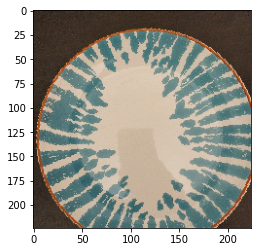

In [ ]:
# Получаем первый батч изображений
X_batch, y_batch = next(iter(train_dataloader))

# Восстанавливаем картинку из "нормализованного состояния"
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


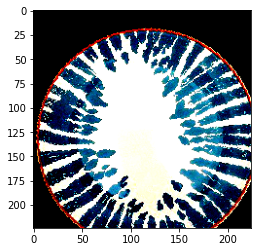

In [ ]:
plt.imshow(X_batch[0].permute(1, 2, 0))

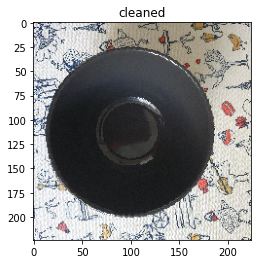

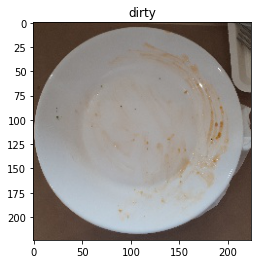

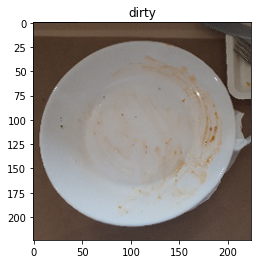

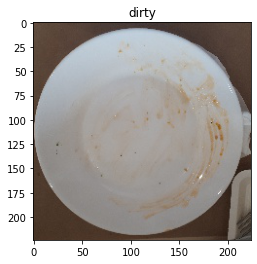

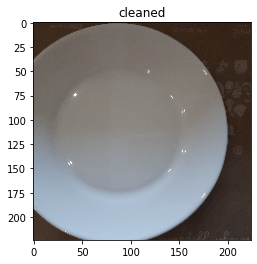

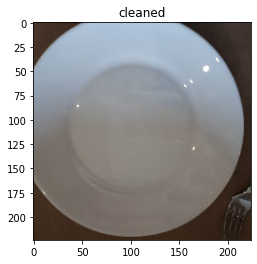

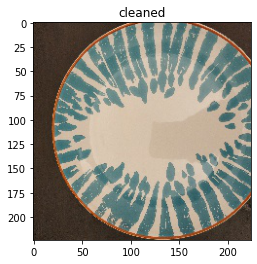

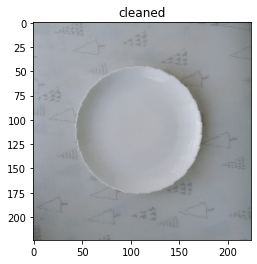

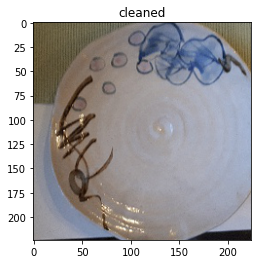

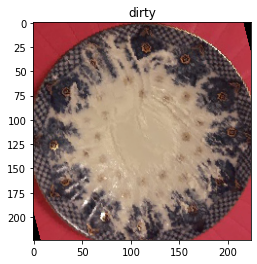

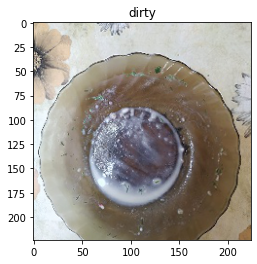

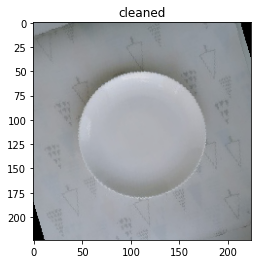

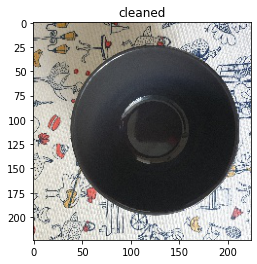

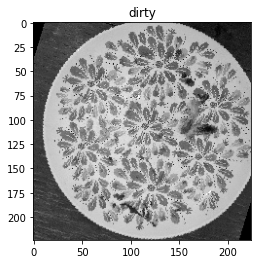

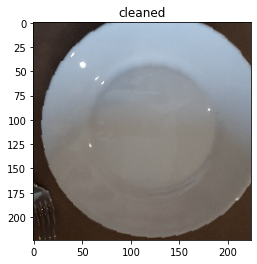

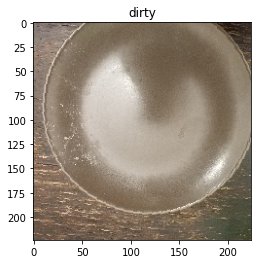

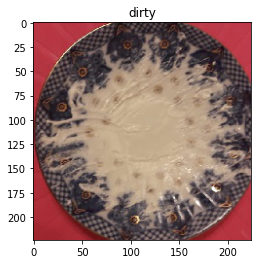

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))
class_names = ['cleaned', 'dirty']

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
# Структура модели - архитектура, лосс-функция, оптимайзер, планировщик уменьшения шага оптимайзера
# Модель - предтренированный resnet
model = models.resnet50(pretrained=True)

# Disable grad for all conv layers
# Сеть уже неплохо обучена, в результате её работы перед последним FC-слоем мы полуаем вектор 512х1
# Тогда, имея всего 40 изображений в трэйне, имеет смысл дообучить веса последнего слоя
# Т.е. обучать веса для установления зависимости между вектором 512х1 и результатом работы сети (чистая или грязная тарелка)
for param in model.parameters():
    # Здесь param - параметры текущего слоя сети, т.е. мы "замораживаем" всю сеть целиком, не давая считать новые градиенты
    param.requires_grad = False

# Но обучение проводилось на 1000 классах (ImageNet), поэтому нужно переделать последний FC-слой сети для 2 классов
# Достаточно указать model.fc для подобного переделывания, градиенты по умолчанию считаются
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # model.fc.in_features - и есть наш вектор 512х1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
# Уменьшение шага градиентного спуска на 0.1 за каждые 7 эпох
# !посмотреть какие есть методы по изменению шага градиентного спуска!
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.05)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
# Final parameters:
# model - resnet50 with corrected lst (FC) layer
# loss - CrossEntropy
# optimizer - Adam with changed learning rate (= 3.0e-4 instead of 1.0e-3)
# scheduler - learning rate decreasing every 7 steps by 0.5 (insted of 1)

# 10 bathces, consisted of 16 images

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode // Forward propagation (?)
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 16/16 [00:03<00:00,  4.75it/s]

train Loss: 0.6407 Acc: 0.6765



100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

val Loss: 0.4231 Acc: 0.8412
Epoch 1/99:



100%|██████████| 16/16 [00:03<00:00,  4.91it/s]

train Loss: 0.4202 Acc: 0.8125



100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

val Loss: 0.3056 Acc: 0.9118
Epoch 2/99:



100%|██████████| 16/16 [00:03<00:00,  4.85it/s]

train Loss: 0.3168 Acc: 0.8750



100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

val Loss: 0.2184 Acc: 0.9235
Epoch 3/99:



100%|██████████| 16/16 [00:03<00:00,  5.02it/s]

train Loss: 0.2119 Acc: 0.9596



100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

val Loss: 0.1516 Acc: 0.9706
Epoch 4/99:



100%|██████████| 16/16 [00:03<00:00,  4.91it/s]

train Loss: 0.1782 Acc: 0.9632



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.1244 Acc: 0.9941
Epoch 5/99:



100%|██████████| 16/16 [00:03<00:00,  4.83it/s]

train Loss: 0.1633 Acc: 0.9522



100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

val Loss: 0.1172 Acc: 0.9824
Epoch 6/99:



100%|██████████| 16/16 [00:03<00:00,  4.97it/s]

train Loss: 0.1449 Acc: 0.9669



100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

val Loss: 0.1031 Acc: 0.9941
Epoch 7/99:



100%|██████████| 16/16 [00:03<00:00,  4.80it/s]

train Loss: 0.1459 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

val Loss: 0.0999 Acc: 0.9941
Epoch 8/99:



100%|██████████| 16/16 [00:03<00:00,  4.79it/s]

train Loss: 0.1650 Acc: 0.9596



100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

val Loss: 0.1058 Acc: 0.9941
Epoch 9/99:



100%|██████████| 16/16 [00:03<00:00,  5.02it/s]

train Loss: 0.1450 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

val Loss: 0.1081 Acc: 0.9824
Epoch 10/99:



100%|██████████| 16/16 [00:03<00:00,  4.77it/s]

train Loss: 0.1520 Acc: 0.9596



100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

val Loss: 0.1025 Acc: 0.9941
Epoch 11/99:



100%|██████████| 16/16 [00:03<00:00,  4.90it/s]

train Loss: 0.1736 Acc: 0.9669



100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

val Loss: 0.0978 Acc: 1.0000
Epoch 12/99:



100%|██████████| 16/16 [00:03<00:00,  4.75it/s]

train Loss: 0.1449 Acc: 0.9669



100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

val Loss: 0.1004 Acc: 0.9882
Epoch 13/99:



100%|██████████| 16/16 [00:03<00:00,  4.87it/s]

train Loss: 0.1575 Acc: 0.9632



100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

val Loss: 0.0953 Acc: 0.9941
Epoch 14/99:



100%|██████████| 16/16 [00:03<00:00,  4.83it/s]

train Loss: 0.1274 Acc: 0.9890



100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

val Loss: 0.1005 Acc: 0.9882
Epoch 15/99:



100%|██████████| 16/16 [00:03<00:00,  4.82it/s]

train Loss: 0.1260 Acc: 0.9890



100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

val Loss: 0.0961 Acc: 0.9941
Epoch 16/99:



100%|██████████| 16/16 [00:03<00:00,  4.89it/s]

train Loss: 0.1570 Acc: 0.9632



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.0989 Acc: 1.0000
Epoch 17/99:



100%|██████████| 16/16 [00:03<00:00,  4.72it/s]

train Loss: 0.1405 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

val Loss: 0.0978 Acc: 1.0000
Epoch 18/99:



100%|██████████| 16/16 [00:03<00:00,  4.75it/s]

train Loss: 0.1646 Acc: 0.9522



100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

val Loss: 0.1009 Acc: 0.9882
Epoch 19/99:



100%|██████████| 16/16 [00:03<00:00,  4.80it/s]

train Loss: 0.1482 Acc: 0.9706



100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

val Loss: 0.1040 Acc: 0.9824
Epoch 20/99:



100%|██████████| 16/16 [00:03<00:00,  4.89it/s]

train Loss: 0.1641 Acc: 0.9706



100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

val Loss: 0.0998 Acc: 1.0000
Epoch 21/99:



100%|██████████| 16/16 [00:03<00:00,  4.92it/s]

train Loss: 0.1480 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

val Loss: 0.0968 Acc: 1.0000
Epoch 22/99:



100%|██████████| 16/16 [00:03<00:00,  4.91it/s]

train Loss: 0.1517 Acc: 0.9779



100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

val Loss: 0.0930 Acc: 0.9941
Epoch 23/99:



100%|██████████| 16/16 [00:03<00:00,  4.77it/s]

train Loss: 0.1285 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

val Loss: 0.1001 Acc: 0.9941
Epoch 24/99:



100%|██████████| 16/16 [00:03<00:00,  4.71it/s]

train Loss: 0.2123 Acc: 0.9265



100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

val Loss: 0.0988 Acc: 1.0000
Epoch 25/99:



100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

train Loss: 0.1412 Acc: 0.9706



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.1008 Acc: 1.0000
Epoch 26/99:



100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

train Loss: 0.1377 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

val Loss: 0.0964 Acc: 0.9941
Epoch 27/99:



100%|██████████| 16/16 [00:03<00:00,  4.74it/s]

train Loss: 0.1310 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

val Loss: 0.0938 Acc: 1.0000
Epoch 28/99:



100%|██████████| 16/16 [00:03<00:00,  4.81it/s]

train Loss: 0.1501 Acc: 0.9853



100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

val Loss: 0.1009 Acc: 0.9941
Epoch 29/99:



100%|██████████| 16/16 [00:03<00:00,  4.83it/s]

train Loss: 0.1702 Acc: 0.9596



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.1007 Acc: 0.9882
Epoch 30/99:



100%|██████████| 16/16 [00:03<00:00,  4.79it/s]

train Loss: 0.1492 Acc: 0.9632



100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

val Loss: 0.1013 Acc: 0.9941
Epoch 31/99:



100%|██████████| 16/16 [00:03<00:00,  4.67it/s]

train Loss: 0.1225 Acc: 0.9890



100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

val Loss: 0.0987 Acc: 1.0000
Epoch 32/99:



100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

train Loss: 0.1639 Acc: 0.9632



100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

val Loss: 0.1020 Acc: 0.9882
Epoch 33/99:



100%|██████████| 16/16 [00:03<00:00,  4.78it/s]

train Loss: 0.1493 Acc: 0.9853



100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

val Loss: 0.0966 Acc: 0.9941
Epoch 34/99:



100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

train Loss: 0.1631 Acc: 0.9596



100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

val Loss: 0.0895 Acc: 0.9941
Epoch 35/99:



100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

train Loss: 0.1299 Acc: 0.9926



100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

val Loss: 0.0984 Acc: 1.0000
Epoch 36/99:



100%|██████████| 16/16 [00:03<00:00,  4.58it/s]

train Loss: 0.1400 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

val Loss: 0.0996 Acc: 1.0000
Epoch 37/99:



100%|██████████| 16/16 [00:03<00:00,  4.80it/s]

train Loss: 0.1525 Acc: 0.9632



100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

val Loss: 0.0948 Acc: 1.0000
Epoch 38/99:



100%|██████████| 16/16 [00:03<00:00,  4.70it/s]

train Loss: 0.1352 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

val Loss: 0.1025 Acc: 0.9882
Epoch 39/99:



100%|██████████| 16/16 [00:03<00:00,  4.80it/s]

train Loss: 0.1477 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

val Loss: 0.1019 Acc: 0.9941
Epoch 40/99:



100%|██████████| 16/16 [00:03<00:00,  4.67it/s]

train Loss: 0.1518 Acc: 0.9706



100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

val Loss: 0.0968 Acc: 1.0000
Epoch 41/99:



100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

train Loss: 0.1346 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.0917 Acc: 1.0000
Epoch 42/99:



100%|██████████| 16/16 [00:03<00:00,  4.75it/s]

train Loss: 0.1405 Acc: 0.9853



100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

val Loss: 0.0990 Acc: 0.9941
Epoch 43/99:



100%|██████████| 16/16 [00:03<00:00,  4.79it/s]

train Loss: 0.1445 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

val Loss: 0.0950 Acc: 0.9824
Epoch 44/99:



100%|██████████| 16/16 [00:03<00:00,  4.75it/s]

train Loss: 0.1602 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

val Loss: 0.0993 Acc: 1.0000
Epoch 45/99:



100%|██████████| 16/16 [00:03<00:00,  4.75it/s]

train Loss: 0.1369 Acc: 0.9779



100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

val Loss: 0.1008 Acc: 0.9882
Epoch 46/99:



100%|██████████| 16/16 [00:03<00:00,  4.83it/s]

train Loss: 0.1562 Acc: 0.9669



100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

val Loss: 0.1008 Acc: 1.0000
Epoch 47/99:



100%|██████████| 16/16 [00:03<00:00,  4.82it/s]

train Loss: 0.1497 Acc: 0.9779



100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

val Loss: 0.1000 Acc: 0.9882
Epoch 48/99:



100%|██████████| 16/16 [00:03<00:00,  4.74it/s]

train Loss: 0.1335 Acc: 0.9779



100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

val Loss: 0.0984 Acc: 0.9941
Epoch 49/99:



100%|██████████| 16/16 [00:03<00:00,  4.84it/s]

train Loss: 0.1677 Acc: 0.9669



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.1008 Acc: 0.9882
Epoch 50/99:



100%|██████████| 16/16 [00:03<00:00,  4.80it/s]

train Loss: 0.1613 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

val Loss: 0.0971 Acc: 1.0000
Epoch 51/99:



100%|██████████| 16/16 [00:03<00:00,  4.81it/s]

train Loss: 0.1455 Acc: 0.9596



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.0956 Acc: 1.0000
Epoch 52/99:



100%|██████████| 16/16 [00:03<00:00,  4.74it/s]

train Loss: 0.1279 Acc: 0.9890



100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

val Loss: 0.0967 Acc: 0.9941
Epoch 53/99:



100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

train Loss: 0.1659 Acc: 0.9596



100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

val Loss: 0.1066 Acc: 1.0000
Epoch 54/99:



100%|██████████| 16/16 [00:03<00:00,  4.75it/s]

train Loss: 0.1437 Acc: 0.9706



100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

val Loss: 0.1007 Acc: 0.9941
Epoch 55/99:



100%|██████████| 16/16 [00:03<00:00,  4.77it/s]

train Loss: 0.1668 Acc: 0.9632



100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

val Loss: 0.1044 Acc: 0.9941
Epoch 56/99:



100%|██████████| 16/16 [00:03<00:00,  4.72it/s]

train Loss: 0.1677 Acc: 0.9632



100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

val Loss: 0.0998 Acc: 1.0000
Epoch 57/99:



100%|██████████| 16/16 [00:03<00:00,  4.70it/s]

train Loss: 0.1489 Acc: 0.9706



100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

val Loss: 0.0978 Acc: 0.9941
Epoch 58/99:



100%|██████████| 16/16 [00:03<00:00,  4.89it/s]

train Loss: 0.1297 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

val Loss: 0.1010 Acc: 0.9941
Epoch 59/99:



100%|██████████| 16/16 [00:03<00:00,  4.85it/s]

train Loss: 0.1315 Acc: 0.9926



100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

val Loss: 0.0972 Acc: 0.9882
Epoch 60/99:



100%|██████████| 16/16 [00:03<00:00,  4.77it/s]

train Loss: 0.1390 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

val Loss: 0.1019 Acc: 0.9941
Epoch 61/99:



100%|██████████| 16/16 [00:03<00:00,  4.78it/s]

train Loss: 0.1610 Acc: 0.9596



100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

val Loss: 0.0999 Acc: 0.9882
Epoch 62/99:



100%|██████████| 16/16 [00:03<00:00,  4.82it/s]

train Loss: 0.1518 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

val Loss: 0.1099 Acc: 0.9882
Epoch 63/99:



100%|██████████| 16/16 [00:03<00:00,  4.81it/s]

train Loss: 0.1373 Acc: 0.9779



100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

val Loss: 0.0996 Acc: 1.0000
Epoch 64/99:



100%|██████████| 16/16 [00:03<00:00,  4.86it/s]

train Loss: 0.1478 Acc: 0.9706



100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

val Loss: 0.0988 Acc: 0.9882
Epoch 65/99:



100%|██████████| 16/16 [00:03<00:00,  4.64it/s]

train Loss: 0.1417 Acc: 0.9890



100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

val Loss: 0.0942 Acc: 1.0000
Epoch 66/99:



100%|██████████| 16/16 [00:03<00:00,  4.69it/s]

train Loss: 0.1542 Acc: 0.9559



100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

val Loss: 0.0985 Acc: 0.9941
Epoch 67/99:



100%|██████████| 16/16 [00:03<00:00,  4.81it/s]

train Loss: 0.1432 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

val Loss: 0.1033 Acc: 1.0000
Epoch 68/99:



100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

train Loss: 0.1708 Acc: 0.9632



100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

val Loss: 0.1019 Acc: 0.9941
Epoch 69/99:



100%|██████████| 16/16 [00:03<00:00,  4.80it/s]

train Loss: 0.1442 Acc: 0.9779



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.1027 Acc: 0.9941
Epoch 70/99:



100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

train Loss: 0.1419 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

val Loss: 0.0959 Acc: 0.9941
Epoch 71/99:



100%|██████████| 16/16 [00:03<00:00,  4.75it/s]

train Loss: 0.1379 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

val Loss: 0.0983 Acc: 1.0000
Epoch 72/99:



100%|██████████| 16/16 [00:03<00:00,  4.75it/s]

train Loss: 0.1447 Acc: 0.9779



100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

val Loss: 0.1009 Acc: 1.0000
Epoch 73/99:



100%|██████████| 16/16 [00:03<00:00,  4.87it/s]

train Loss: 0.1635 Acc: 0.9669



100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

val Loss: 0.0929 Acc: 0.9941
Epoch 74/99:



100%|██████████| 16/16 [00:03<00:00,  4.72it/s]

train Loss: 0.1349 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

val Loss: 0.0976 Acc: 0.9941
Epoch 75/99:



100%|██████████| 16/16 [00:03<00:00,  4.86it/s]

train Loss: 0.1354 Acc: 0.9890



100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

val Loss: 0.0988 Acc: 1.0000
Epoch 76/99:



100%|██████████| 16/16 [00:03<00:00,  4.94it/s]

train Loss: 0.1388 Acc: 0.9706



100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

val Loss: 0.0987 Acc: 0.9941
Epoch 77/99:



100%|██████████| 16/16 [00:03<00:00,  4.77it/s]

train Loss: 0.1443 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.1021 Acc: 0.9941
Epoch 78/99:



100%|██████████| 16/16 [00:03<00:00,  4.82it/s]

train Loss: 0.1782 Acc: 0.9485



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.0962 Acc: 1.0000
Epoch 79/99:



100%|██████████| 16/16 [00:03<00:00,  4.72it/s]

train Loss: 0.1303 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

val Loss: 0.0982 Acc: 0.9941
Epoch 80/99:



100%|██████████| 16/16 [00:03<00:00,  4.74it/s]

train Loss: 0.1622 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

val Loss: 0.0962 Acc: 0.9941
Epoch 81/99:



100%|██████████| 16/16 [00:03<00:00,  4.66it/s]

train Loss: 0.1207 Acc: 0.9853



100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

val Loss: 0.0946 Acc: 1.0000
Epoch 82/99:



100%|██████████| 16/16 [00:03<00:00,  4.77it/s]

train Loss: 0.1333 Acc: 0.9779



100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

val Loss: 0.1021 Acc: 0.9941
Epoch 83/99:



100%|██████████| 16/16 [00:03<00:00,  4.71it/s]

train Loss: 0.1545 Acc: 0.9596



100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

val Loss: 0.1050 Acc: 0.9882
Epoch 84/99:



100%|██████████| 16/16 [00:03<00:00,  4.90it/s]

train Loss: 0.1402 Acc: 0.9779



100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

val Loss: 0.0990 Acc: 1.0000
Epoch 85/99:



100%|██████████| 16/16 [00:03<00:00,  4.70it/s]

train Loss: 0.1432 Acc: 0.9853



100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

val Loss: 0.1011 Acc: 0.9882
Epoch 86/99:



100%|██████████| 16/16 [00:03<00:00,  4.83it/s]

train Loss: 0.1698 Acc: 0.9596



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.1040 Acc: 0.9941
Epoch 87/99:



100%|██████████| 16/16 [00:03<00:00,  4.79it/s]

train Loss: 0.1328 Acc: 0.9779



100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

val Loss: 0.0962 Acc: 1.0000
Epoch 88/99:



100%|██████████| 16/16 [00:03<00:00,  4.72it/s]

train Loss: 0.1485 Acc: 0.9816



100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

val Loss: 0.0961 Acc: 1.0000
Epoch 89/99:



100%|██████████| 16/16 [00:03<00:00,  4.69it/s]

train Loss: 0.1524 Acc: 0.9743



100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

val Loss: 0.1006 Acc: 0.9882
Epoch 90/99:



100%|██████████| 16/16 [00:03<00:00,  4.79it/s]

train Loss: 0.1263 Acc: 0.9853



100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

val Loss: 0.0994 Acc: 0.9941
Epoch 91/99:



100%|██████████| 16/16 [00:03<00:00,  4.80it/s]

train Loss: 0.1313 Acc: 0.9853



100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

val Loss: 0.0999 Acc: 0.9941
Epoch 92/99:



100%|██████████| 16/16 [00:03<00:00,  4.82it/s]

train Loss: 0.1897 Acc: 0.9412



100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

val Loss: 0.1005 Acc: 1.0000
Epoch 93/99:



100%|██████████| 16/16 [00:03<00:00,  4.72it/s]

train Loss: 0.1370 Acc: 0.9779



100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

val Loss: 0.0908 Acc: 1.0000
Epoch 94/99:



100%|██████████| 16/16 [00:03<00:00,  4.70it/s]

train Loss: 0.1937 Acc: 0.9449



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

val Loss: 0.1030 Acc: 0.9882
Epoch 95/99:



100%|██████████| 16/16 [00:03<00:00,  4.71it/s]

train Loss: 0.1340 Acc: 0.9853



100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

val Loss: 0.1070 Acc: 0.9824
Epoch 96/99:



100%|██████████| 16/16 [00:03<00:00,  4.77it/s]

train Loss: 0.1497 Acc: 0.9706



100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

val Loss: 0.0980 Acc: 0.9941
Epoch 97/99:



100%|██████████| 16/16 [00:03<00:00,  4.75it/s]

train Loss: 0.1751 Acc: 0.9522



100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

val Loss: 0.0960 Acc: 1.0000
Epoch 98/99:



100%|██████████| 16/16 [00:03<00:00,  4.74it/s]

train Loss: 0.1528 Acc: 0.9706



100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

val Loss: 0.1050 Acc: 0.9882
Epoch 99/99:



100%|██████████| 16/16 [00:03<00:00,  4.84it/s]

train Loss: 0.1715 Acc: 0.9669



100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

val Loss: 0.1050 Acc: 0.9941


In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [ ]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
!ls

plates.zip  sample_data  test  train  val


In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 44/44 [00:06<00:00,  7.09it/s]


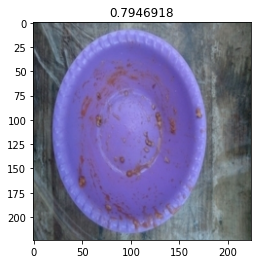

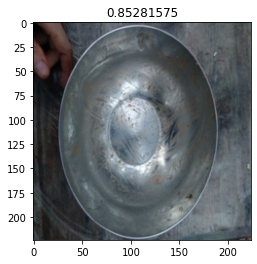

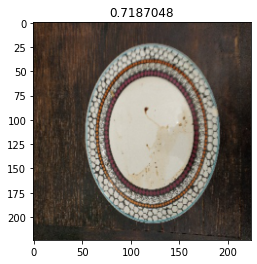

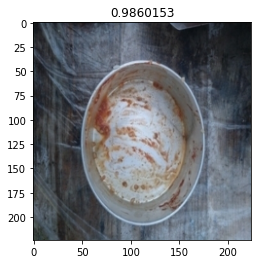

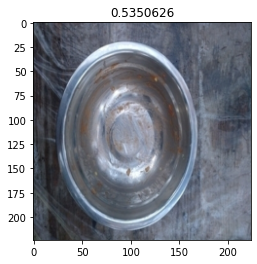

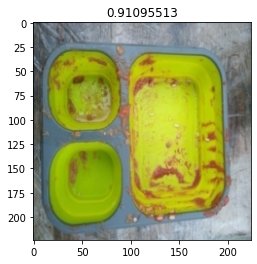

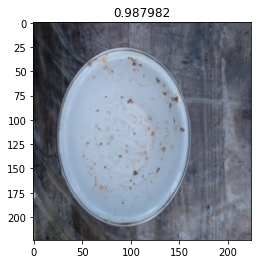

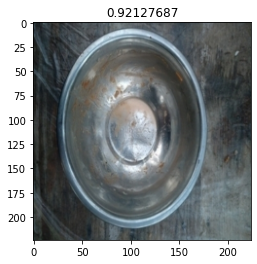

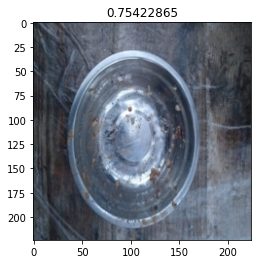

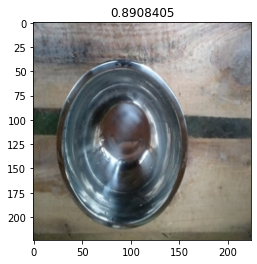

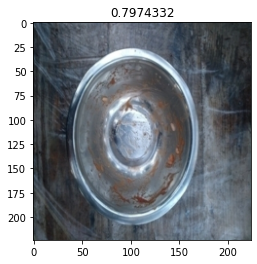

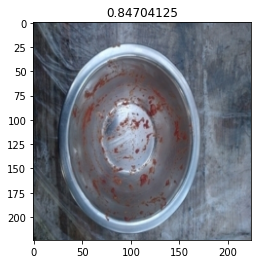

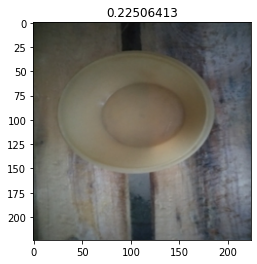

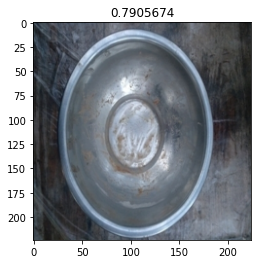

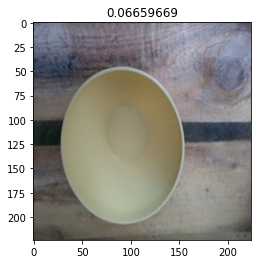

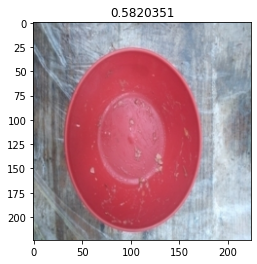

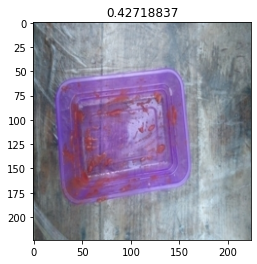

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id         
0000  dirty
0001  dirty
0002  dirty
0003  dirty
0004  dirty
0005  dirty

In [ ]:
submission_df.to_csv('my_submission.csv')

In [ ]:
!rm -rf train val test